# CNN Preprocessing User Guide 

Copy the EEM (from any format, including OPJ) into an Excel spreadsheet with the excitation wavelength labels occupying the first row and emission wavelength labels occupying the first column. If you have multiple EEMs, use multiple spreadsheets, __not__ different tabs within a single sheet. 

As always, first load your modules.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import scipy as sp
import matplotlib.pyplot as plt

Below is written several functions to automize EEM preparation. Above each function is a brief description, and the function inputs and outputs are described in detail within the functions themselves (in red).

This function crops whatever EEM is uploaded into a an (mxm) matrix with the number of rows and columns being the number excitation wavelengths. You are able to choose which emission wavelength you want to start at depending on where you expect the fluorescent peaks to be.  

In [2]:
def croprange(X,a):
    '''
    inputs: 
    X --> EEM as a dataframe
    a --> The desired 1st emission wavelength
    output:
    X, cropped from a to len(number of columns in X), aka: as a mxm df
    '''
    ex_range = len(X.columns[1:])
    rows=X.iloc[:,0]
    row_ind=X.index[rows==a].values.astype(str).astype(int)
    row_ind=row_ind[0]
    #315 --> 565
    X=X.loc[row_ind:row_ind+ex_range,:]
    X=X.reset_index(drop=True)
    return(X)

This function pads the EEM into a square matrix if you don't want to cut any of the existing matrix off (ie: the situation in which you have peaks at each end of your EEM). 

In [3]:
def padsquare(X):
    """
     inputs: 
    X --> EEM as a dataframe
    output:
    X, padded to the mxm matrix where m is the number of excitation wavelengths
    """
    columns = len(X.columns[1:].values)
    rows=len(X.iloc[:,0].values)
    if rows>columns:
        dif=rows-columns-1
        pad=pd.DataFrame(0,index=range(rows),columns=range(dif))
        X=pd.concat([X,pad],axis=1)
        return(X)
    if columns>rows:
        dif=columns-rows-1
        pad=pd.DataFrame(0,index=range(dif),columns=range(columns))
        X=pd.concat([X,pad])
        return(X)

Below are two helper functions for "unscatter" below. The frist finds the wavelength of the peak Raman scatter and returns that as a list. The second is used if the user wants to interpolate where the raman scatter is.

In [4]:
def findraman(X,order):
    '''
    inputs: 
    X --> EEM as a dataframe
    order --> 1st or 2nd order raman scatter
    output: raman_peak_list = an int list of the emission wavelengths
            where the raman scatter peaks live
    '''
    raman_peak_list=[]
    columns = X.columns[1:]
    for ex in columns:
        ex=int(ex)
        raman_peak=(-order*ex)/(.00036*ex-1)
        raman_peak_list.append(round(raman_peak))
    return(raman_peak_list)

def interpolate(X):
    """
    inputs: 
    X --> EEM as a dataframe
    output: where the raman scatter was found to be is interpolated from the rest of the EEM with a second order polynomial
    """
    X.interpolate(method='quadratic', inplace=True, limit_direction='both')
    rows=X.iloc[:,0]
    for row in range(len(rows)):
        new_row=X.iloc[row,:].copy()
        interpolated=new_row.interpolate(method='linear')
        X.iloc[row,:]=interpolated
    return(X)

This is the main preprocessing function. It is intended to remove 1st and 2nd order Raman and Rayleigh scattering and interpolate the removed wavelengths. You are able to adjust the number of nanometers you want removed on either side of the peak Raman scatter as well as interpolate the removed values.

In [5]:
def unscatter(X,kind,order,width,inter):
    '''
    inputs: 
    X --> EEM as a dataframe
    kind --> 0: raman or 1: raleigh depending on scatter
    order --> 1 or 2, 1st or 2nd order outputs: EEM with scatter specified removed
    width=nm desired to remove on either side of the raman scatter peak
    inter=True/False interpolate the missing values or not
    
    outputs:
    X with scatter taken out at desired width
    '''
    if kind==0:
        #the row/emission values of center of raman scatter 
        ram_em=findraman(X,order)
        #empty list to fill with all emissions to be removed (whether or not present in the df)
        ram_em_list=[]
        #empty list to fill with row/emission indices associated with ram_em
        ram_ind=[]
        #dataframe of the rows
        rows=X.iloc[:,0]
        #columns_int = df.columns[1:].values.astype(str).astype(int).tolist()
        #dataframe of the columns
        columns = X.columns[1:]
        #this forloop expands the nm around ram_em to include a width given by arg="width"
        for r in ram_em:
            ram_em_placehold=[]
            ram_em_placehold.append(r)
            for w in np.arange(width):
                ram_em_placehold.append(r+w+1)
                ram_em_placehold.append(r-w-1)
            ram_em_placehold.sort()
            ram_em_list.append(ram_em_placehold)
        #this forloop turns from em values to em indices of ram_em_list
        for r in ram_em_list:
            ind=[]
            for r2 in r:
                placehold=X.index[rows==r2].values.astype(str).astype(int).tolist()
                for r3 in placehold:
                    ind.append(r3)
            ram_ind.append(ind)
        indpt=1
        #this forloop goes to the appropriate index and deletes the scatter
        for ram in ram_ind:
            for ram1 in ram:
                ram1=int(ram1)
                X.iloc[ram1,indpt]=np.nan
            indpt=indpt+1
    
    if kind==1:
        #the emissions at which the peak rayleigh will be
        ral_em=X.columns[1:].values.astype(str).astype(int)
        ral_em=order*ral_em
        #creating dataframe just of rows
        rows=X.iloc[:,0]
        #creating an integer list of the rows
        rows_as_list=rows.values
        #empty lists for use in forloops
        ral_em_list=[]
        ral_row_ind=[]
        ral_col_ind=[]
        #calculating the emissions for which we want to remove the rayleigh depending on width
        for r in ral_em:
            ral_em_placehold=[]
            ral_em_placehold.append(r)
            for w in np.arange(width):
                ral_em_placehold.append(r+w+1)
                ral_em_placehold.append(r-w-1)
            ral_em_placehold.sort()
            ral_em_list.append(ral_em_placehold)
        #to turn the emission number (nm) into an index
        for r in ral_em_list:
            ind=[]
            for r2 in r:
                r3_prep=X.index[rows==r2].values.astype(str).astype(int).tolist()
                for r3 in r3_prep:
                    ind.append(r3)
            ral_row_ind.append(ind)
        indpt=1
        #this forloop runs through the columns and rows, pairing them to remove scatter
        for ral in ral_row_ind:
            for ral1 in ral:
                ral1=int(ral1)
                X.iloc[ral1,indpt]=np.nan
            indpt=indpt+1   
    if inter:
        interpolate(X)
    return(X)

The below function turns the dataframe into a greyscale image and saves it to a folder on the user's computer (The user will need to manually input the correct path for this).

In [6]:
def as_jpg(X,savepath,name):
    """
    inputs:
    X: a mxm dataframe
    name: a string name
    savepath: where the new jpg will be saved
    outputs: 
    a mxm np array scaled to grayscale image range
    """
    from PIL import Image
    X_array=pd.DataFrame.to_numpy(X.iloc[:,1:])
    X_scaled = 255*((X_array - X_array.min()) / (X_array.max() - X_array.min()))
    img=Image.fromarray(X_scaled)
    img=img.convert("L")
    filepath=os.path.join(savepath,name,'jpg')
    img.save(filepath)

Here is an example of the process. We begin by padding the excitation wavelength so that the (x,y) dimensions are the same. Then we show the EEM before and after removing the first and second order Raman and Rayleigh scatter. We create a colored contour plot for presentation purposes.

If one is using preprocessing to build a CNN, one must create square images. If we examine the shape of the sample EEM below we see that it is not square, having 87 rows and 52 columns. To achieve this when the EEMs are __not__ square, we can either add padding (of "0"s) onto the shorter dimension, or crop the longer dimension to meet the shorter one. 

(87, 52)


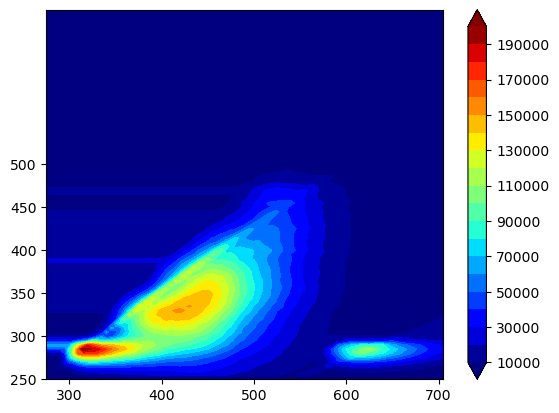

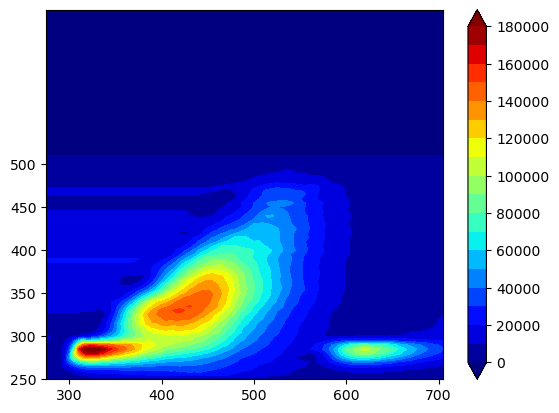

In [7]:
df=pd.read_csv(r"C:\Users\maiaz\Desktop\Corradini Lab\CNN Data\AmBD1\AmBD1 (1).csv",header=0)

print(df.shape)
df.head()

#All this is for creating figures for the paper:
l_x=[250,300,350,400,450,500]
l_y=[300,400,500,600,700]
ticksx=[5,25,45,65,85]
ticksy=[0,10,20,30,40,50]

df=padsquare(df)
df=df.transpose()
CP_pre=plt.contourf(df, levels=20, cmap='jet', extend='both')
plt.xticks(ticks=ticksx,labels=l_y);
plt.yticks(ticks=ticksy,labels=l_x);
plt.colorbar()
df=df.transpose()
plt.show()

unscatter(df,0,1,10,True)
unscatter(df,0,2,10,True)
unscatter(df,1,1,20,True)
unscatter(df,1,2,20,True)

df=df.transpose()
CP_post=plt.contourf(df, levels=20, cmap='jet', extend='both')
plt.xticks(ticks=ticksx,labels=l_y);
plt.yticks(ticks=ticksy,labels=l_x);
plt.colorbar()
plt.show()

Now, what if we want to do this to dozens of images without having to manually enter their paths? To do this, we simply collect all the samples we want to apply our functions to in a single folder (it's best to discriminate by sample type, and not lump __everything__ together). So, in our case, the single folder is called "Sample Preprocessing Dataset Raw", and within it are four samples we want to treat at the same time. Notice how they are all of type "AmBD1."

We set this folder as our 'filepath' and then another folder 'Sample Preprocessing Data Post" as the folder where our new images will be saved, called "endfilepath". 

In [ ]:
filepath=r"C:\Users\maiaz\Desktop\Corradini Lab\CNN Data\AmBD1"
endfilepath=r"C:\Users\maiaz\Desktop"
for filename in os.listdir(filepath):
    f = os.path.join(filepath, filename)
    df=pd.read_csv(f,header=0)
    unscatter(df,0,1,10,True)
    unscatter(df,0,2,10,True)
    unscatter(df,1,1,10,True)
    unscatter(df,1,2,10,True)
    df=padsquare(df)
    df=df.transpose()
    as_jpg(df,endfilepath,filename)

Here is an example of a fully pre-processed EEM. Note that it is small because it is only 86x86 pixels.

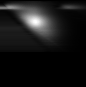
